In [1]:
import numpy as np
import sympy
from qualtran.drawing import show_bloq, show_call_graph

Let us start with a kXOR instance with $n$ variables and $m$ constraints.

In [2]:
from qualtran.bloqs.optimization.k_xor_sat.kxor_instance import KXorInstance

n, m, k = sympy.symbols("n m k", positive=True, integer=True)
inst = KXorInstance.symbolic(n, m, k)
inst

KXorInstance(n=n, k=k, constraints=HasLength(n=m), max_rhs=2)

We first prepare the guiding state to use in the guided sparse hamiltonian algorithm.
The guiding state is defined by the instance, and a parameter $\ell$ (a multiple of $k$)

From Theorem 4.15 of the paper, this should be a circuit of $O(\ell m \log n)$ gates,
and prepare the state $\beta |\Psi\rangle|0^{\ell \log \ell}\rangle + |\perp\rangle|1\rangle$,
where $\beta \ge 0.99 / \ell^{\ell/2}$.

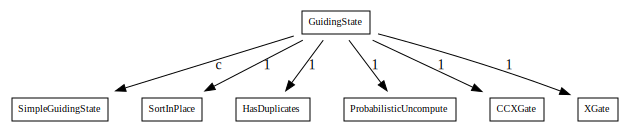

In [3]:
from qualtran.bloqs.optimization.k_xor_sat.kikuchi_guiding_state import GuidingState

c = sympy.symbols("c", positive=True, integer=True)
l = c * k
guiding_state = GuidingState(inst, l)
show_call_graph(guiding_state.call_graph(max_depth=1)[0])

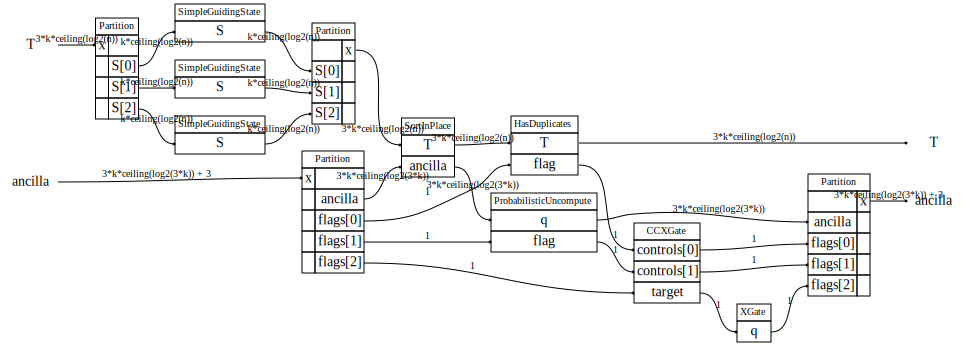

In [4]:
guiding_state_3 = GuidingState(inst, 3 * k)
show_bloq(guiding_state_3.decompose_bloq())

We can also build the guiding state for a concrete (non symbolic) instance:

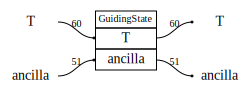

In [5]:
inst = KXorInstance.random_instance(n=20, m=100, k=4, planted_advantage=0.8, rng=np.random.default_rng(100))
guiding_state_concrete = GuidingState(inst, ell=12)
show_bloq(guiding_state_concrete)

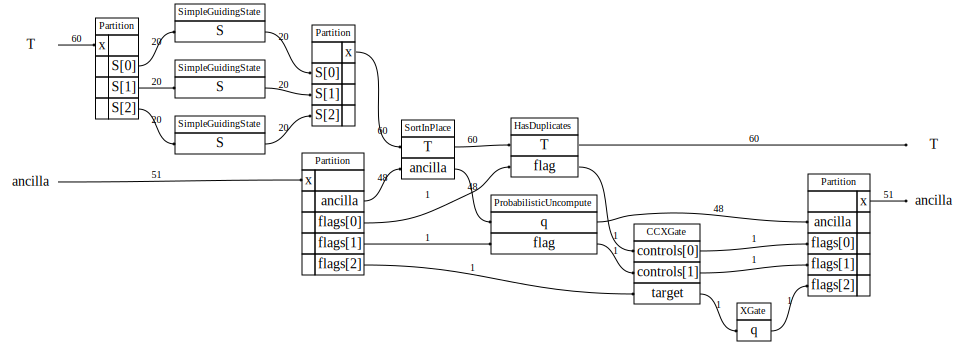

In [6]:
show_bloq(guiding_state_concrete.decompose_bloq())

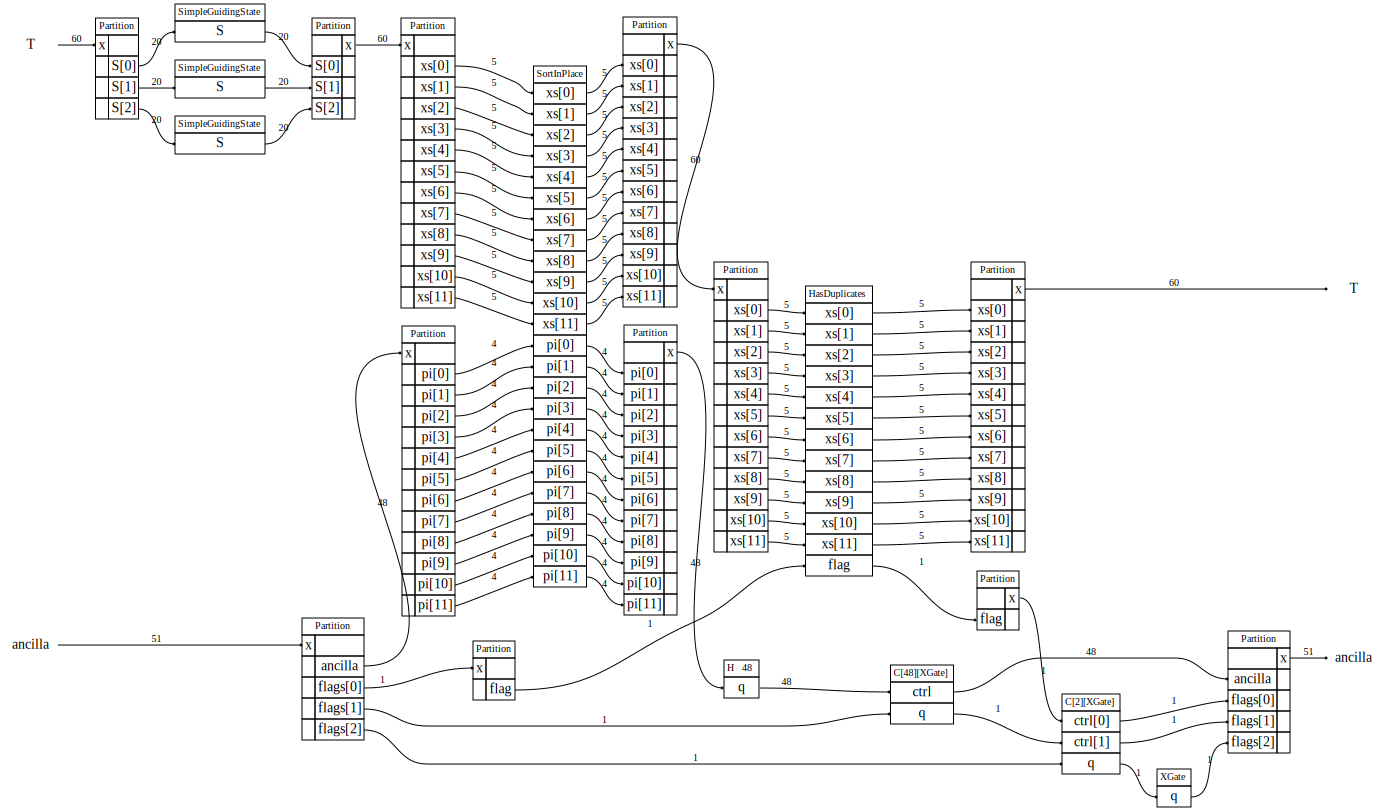

In [7]:
show_bloq(guiding_state_concrete.decompose_bloq().flatten_once())

Let us evaluate the gate cost for the above bloqs.

In [8]:
from qualtran.resource_counting import get_cost_value, QECGatesCost

get_cost_value(guiding_state_concrete, QECGatesCost())

GateCounts(t=0, toffoli=552, cswap=4320, and_bloq=25175, clifford=170846, rotation=0, measurement=25175)

In [9]:
gc = get_cost_value(guiding_state, QECGatesCost())
t_cost = gc.total_t_count(ts_per_toffoli=4, ts_per_cswap=4, ts_per_and_bloq=4)
t_cost

24*c**2*k**2*(2*ceiling(log2(n)) + 1) + 24*c**2*k**2*ceiling(log2(n)) + 4*c*k*ceiling(log2(c*k)) + 4*c*k + 4*c*(2*ceiling(log2(2000000.0*pi*c)) - 4) + 4*c*(4*m + (2*m + 1)*(ceiling(log2(floor(2**(k*ceiling(log2(n)))))) - 1) - 4) + 4*(c*k - 1)*ceiling(log2(n)) - 8

In [10]:
from qualtran.symbolics import ceil, log2, floor
from qualtran.resource_counting import big_O

# simplify some expressions that sympy could not
klogn = k * ceil(log2(n))
klogn_long = ceil(log2(floor(2**klogn)))
t_cost = t_cost.subs(klogn_long, klogn)
t_cost = t_cost.simplify()

# replace l with a symbol
l_symb = sympy.symbols(r"\ell", positive=True, integer=True)
t_cost = t_cost.subs(c * k, l_symb)

big_O(t_cost) # matches paper Theorem 4.15 (as c, l are O(m))

O(\ell**2*log2(n) + \ell*m*log2(n) + c*m + c*log2(2000000.0*pi*c), (\ell, oo), (c, oo), (m, oo), (n, oo))

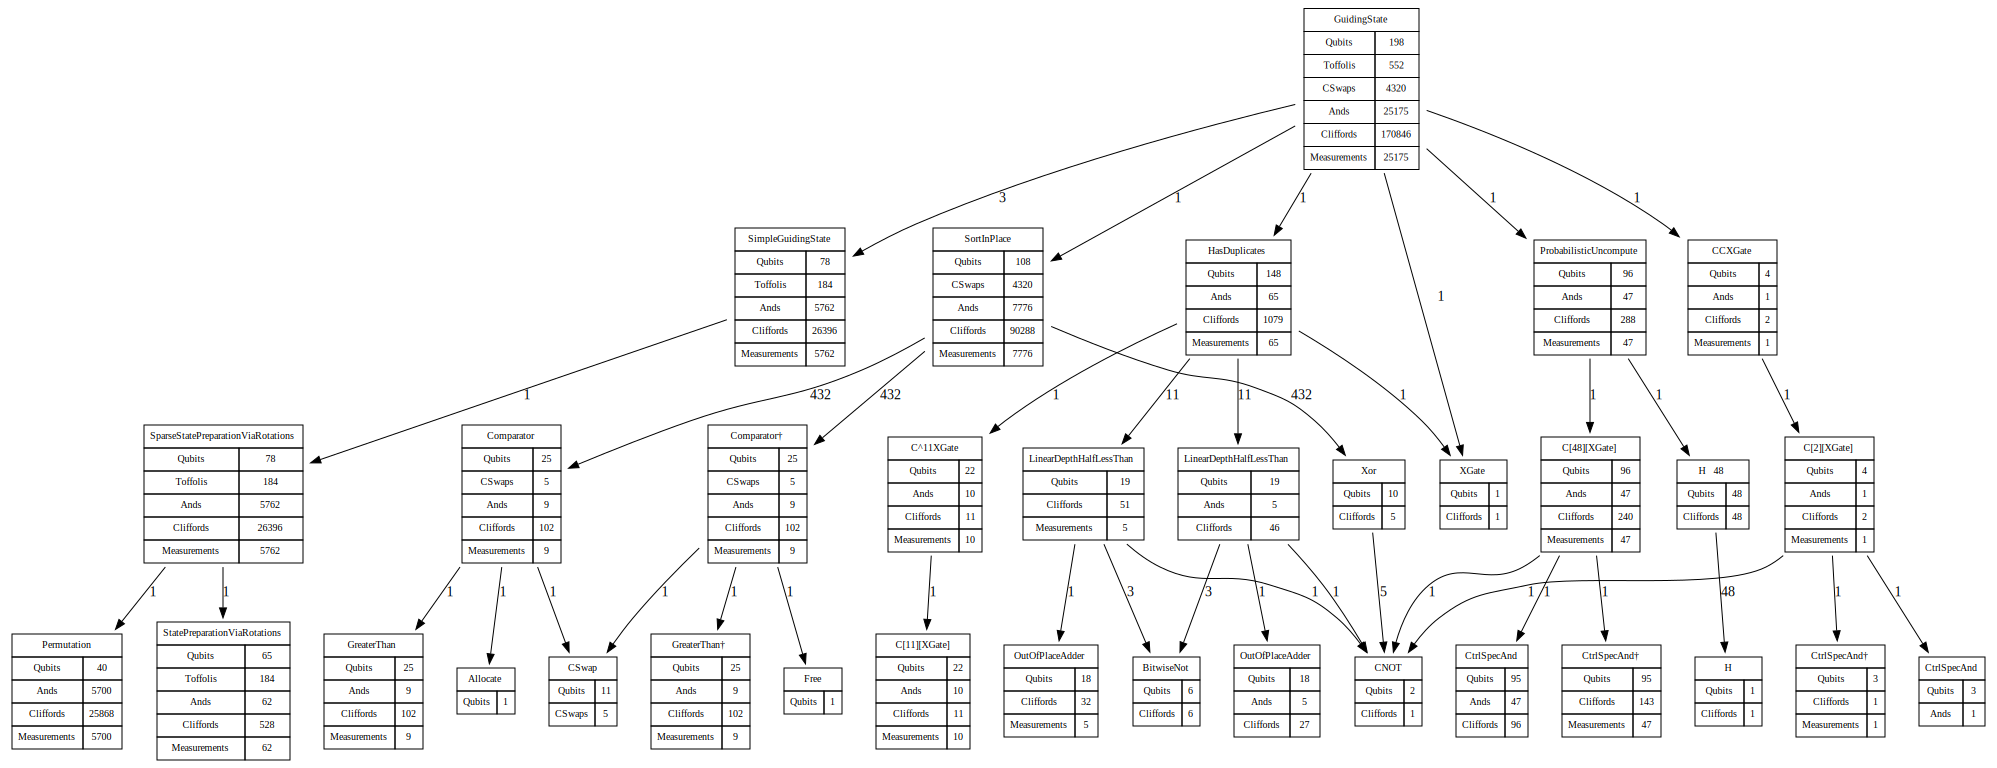

In [11]:
show_call_graph(guiding_state_concrete, max_depth=3)

As we know that $c = \ell/k \le \ell$ and $\ell \le m$, the above expression matches the paper result of $O(\ell m \log_2(n))$ 1/2-qubit gates.
<!-- Here, we synthesize each 1-qubit rotation to precision $2^{-b_\text{grad}}$, with $4 (b_\text{grad}-2)$ T gates using phase gradients. -->